## ひろしまQuest2022 : 河川の水位予想チュートリアル

### [概要]
こちらのチュートリアルでは、簡易的なモデリングを用いて予測値を算出し、提出物を作成する方法について説明します。 説明は以下の流れで構成されています。

1. 準備
2. EDA
3. モデルの作成
4. run_testを使ったモデルの検証
5. モデルの投稿

＊コンペページをご覧いただき課題を理解したら、配布データのダウンロードを行ってください。  
＊配布データと投稿用ファイルの作成、評価システムの実行環境、runtimeについてはreadme.mdをご覧ください。  
＊本チュートリアルでは探索的データ分析(以下EDA)、readme.mdに記載の投稿用ファイルの作成、ローカル環境での検証の実装を行います。  
＊このチュートリアル(tutorial.ipynb)ファイル、配布データのディレクトリ構造は下記のようにおいてください。  

### [1. 準備]

**分析環境**

本チュートリアルは下記分析環境にて正常に動作しております。  

macOS==13.0.1（22A400） 
Python==3.9.13  
ライブラリ  
pandas==1.4.4   
numpy==1.23.1   
matplotlib==3.6.1   
folium==0.13.0  

**ディレクトリ構成**
ディレトクリ構成は下記を想定しております。(本チュートリアルはtutorial.ipynbというファイル名です。)  

<pre>
run_test
├── tutorial_submit
│   ├── model
│   │   └── ...
│   ├── src
│   │   ├── predictor.py    
│   │   └── ...   
│   └── requirements.txt  
├── train   
│   ├── rainfall    
│   │   ├── data.csv    
│   │   └── stations.csv    
│   ├── tidelevel     
│   │   ├── data.csv    
│   │   └── stations.csv    
│   ├── waterlevel    
│   │   ├── data.csv    
│   │   └── stations.csv    
│   └── dam.csv   
├── run.py    
tutorial.ipynb    
</pre>

### ライブラリのインポート

In [32]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib

import folium

### [2. EDA]

In [33]:
import pandas as pd
path = "./Hiroshima-Quest2022/data/train/"

#雨量のデータ読み込み
rain_data = pd.read_csv(path+"rainfall/data.csv")
rain_stations = pd.read_csv(path+"rainfall/stations.csv")
print("shapeの確認")
print("雨量観測データ", rain_data.shape)
print("雨量観測データ", rain_stations.shape)

#潮位のデータの読み込み
tide_data = pd.read_csv(path+"tidelevel/data.csv")
tide_stations = pd.read_csv(path+"tidelevel/stations.csv")
print("潮位観測データ:", tide_data.shape)
print("潮位観測データ所:", tide_stations.shape)

#水位のデータの読み込み
water_data = pd.read_csv(path+"waterlevel/data.csv")
water_stations = pd.read_csv(path+"waterlevel/stations.csv")
print("水位観測データ:", water_data.shape)
print("水位観測データ所:", water_stations.shape)

#damデータの読み込み
dam = pd.read_csv(path+"dam.csv")
print("damデータ:", dam.shape)

shapeの確認
雨量観測データ (896003, 27)
雨量観測データ (313, 11)
潮位観測データ: (28483, 27)
潮位観測データ所: (13, 10)
水位観測データ: (392066, 27)
水位観測データ所: (180, 12)
damデータ: (12, 21)


In [34]:
import folium

map = folium.Map(location=["34.5447", "132.8134"], zoom_start=10, titles="OpenStreetMap")

# ------------水位観測所-------------
water_station = water_stations.dropna(subset=["緯度", "経度"])
for i in range(len(water_station)):
    folium.Circle(radius=150,
                  location=[water_station.iloc[i]['緯度'], water_station.iloc[i]['経度']],
                  tooltip=str(water_station.iloc[i]['観測所名称'] + ' (' + water_station.iloc[i]['フリガナ'] + ')'),
                  color='red', fill=False).add_to(map)


# ------------雨量観測所-------------
rain_station = rain_stations.dropna(subset=["緯度", "経度"])
for i in range(len(rain_station)):
  folium.Circle(radius=150,
                location=[rain_station.iloc[i]["緯度"], rain_station.iloc[i]["経度"]],
                tooltip = str(rain_station.iloc[i]["観測所名称"] + "(" + rain_station.iloc[i]["フリガナ"]+")"),
                color = "blue",fill=False).add_to(map)
# ------------水位観測所-------------
tide_station = tide_stations.dropna(subset=['緯度', '経度'])
for i in range(len(tide_station)):
    folium.Circle(radius=150,
                  location=[tide_station.iloc[i]['緯度'], tide_station.iloc[i]['経度']],
                  tooltip=str(tide_station.iloc[i]['観測所名'] + ' (' + tide_station.iloc[i]['ふりがな'] + ')'),
                  color='green', fill=False).add_to(map)

map

観測所は広島県全域に分布していることがわかります。
海からの距離などで特徴が出るかもしれません。

続いて目的変数となる水位データ(waterlevel)について確認します。

In [35]:
display(water_data.head(5), water_stations.head(5))

,date,station,river,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,0,釜ヶ原,小瀬川,0.76,0.76,0.76,0.76,0.76,0.76,0.76,...,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76
1,0,下ヶ原(国),小瀬川,0.71,0.71,0.71,0.71,0.71,0.71,0.71,...,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71,0.71
2,0,防鹿(国),小瀬川,4.71,4.71,4.7,4.7,4.71,4.71,4.71,...,4.7,4.7,4.71,4.7,4.7,4.7,4.71,4.7,4.7,4.7
3,0,本郷(廿日市),小瀬川,0.31,0.31,0.31,0.32,0.32,0.32,0.31,...,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32
4,0,駄荷(電),太田川,0.39,0.39,0.39,0.39,0.39,0.39,0.39,...,0.39,*,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4


,観測所名称,フリガナ,水系名,河川名,事務所,市町,データ所管,住所,緯度,経度,入力時使用,評価対象
0,多治比,タジヒ,江の川,多治比川,西部建設事務所,安芸高田市,河川課,安芸高田市吉田町多冶比,34.681944,132.667222,1,1
1,南原,ナバラ,太田川,南原川,西部建設事務所,広島市安佐北区,河川課,広島市安佐北区可部町上町屋字下小野1452番2,34.540556,132.501389,1,1
2,向原,ムカイハラ,太田川,三篠川,西部建設事務所,安芸高田市,河川課,安芸高田市向原町長田字田屋３４６２－２地先,34.607306,132.703333,1,1
3,上甲立,カミコウダチ,江の川,本村川,西部建設事務所,安芸高田市,河川課,安芸高田市甲田町上甲立字六地蔵１２５２－１地先,34.708333,132.739444,1,1
4,上安,カミヤス,太田川,安川,西部建設事務所,広島市安佐南区,河川課,広島市安佐南区相田２丁目地先,34.469306,132.460000,1,1


In [36]:
rain_stations

,観測所名称,フリガナ,市町,水系名,河川名,データ所管,住所,緯度,経度,事務所,入力時使用
0,西部建設,セイブケンセツ,広島市南区,太田川,京橋川,河川課,広島市南区比治山本町１６－１２ 西部建設事務所内,34.381667,132.466667,NaN,1
1,上瀬野,カミセノ,広島市安芸区,瀬野川,瀬野川,河川課,広島市安芸区上瀬野瀬野川公園内,34.428333,132.618056,NaN,1
2,熊野町,クマノチョウ,熊野町,二河川,二河川,河川課,安芸郡熊野町３８１５－１ 熊野町役場内,34.338889,132.568056,NaN,1
3,江波,エバ,広島市中区,太田川,天満川,砂防課,広島市中区江波西１丁目１番１３号,34.373111,132.435833,NaN,1
4,福木,フクギ,広島市東区,太田川,小河原川,砂防課,広島市東区馬木９丁目１－２,34.445472,132.535833,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
308,内黒山(気),ウチグロヤマ,NaN,太田川,柴木川,気象台,山県郡安芸太田町大字横川字横川東平,34.591713,132.147980,安芸太田支所,1
309,都志見(気),ツシミ,NaN,太田川,吉木川,気象台,山県郡北広島町都志見,34.647644,132.429581,安芸太田支所,1
310,王泊(気),オオドマリ,NaN,太田川,滝山川,気象台,山県郡北広島町細見,34.729439,132.314102,安芸太田支所,1
311,八幡(気),ヤハタ,NaN,太田川,柴木川,気象台,山県郡北広島町東八幡原,34.709293,132.178879,安芸太田支所,1


In [37]:
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392066 entries, 0 to 392065
Data columns (total 27 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      392066 non-null  int64 
 1   station   392066 non-null  object
 2   river     392066 non-null  object
 3   00:00:00  392063 non-null  object
 4   01:00:00  392063 non-null  object
 5   02:00:00  392063 non-null  object
 6   03:00:00  392063 non-null  object
 7   04:00:00  392063 non-null  object
 8   05:00:00  392063 non-null  object
 9   06:00:00  392063 non-null  object
 10  07:00:00  392063 non-null  object
 11  08:00:00  392063 non-null  object
 12  09:00:00  392063 non-null  object
 13  10:00:00  392063 non-null  object
 14  11:00:00  392063 non-null  object
 15  12:00:00  392066 non-null  object
 16  13:00:00  392066 non-null  object
 17  14:00:00  392066 non-null  object
 18  15:00:00  392066 non-null  object
 19  16:00:00  392066 non-null  object
 20  17:00:00  392066 non-null 

観測データがobject型ということで数字意外の要素があるかもしれないという点と観測所(観測する川)によって数値のスケールが異なっている点の2点を確認します。

In [38]:
water_data[pd.to_numeric(water_data['00:00:00'], errors='coerce').notna()==False]['00:00:00'].unique()

array(['*', 'M', '-', nan], dtype=object)

数値以外にさまざまな記号が入っているので欠損地で統一します。

In [39]:
# 00:00:00~23:00:00の各カラムについてfloat型に変換
for i in range(24):
    water_data[f'{str(i).zfill(2)}:00:00'] = pd.to_numeric(water_data[f'{str(i).zfill(2)}:00:00'], errors='coerce')

In [40]:
# 00:00:00~23:00:00の各カラムについてfloat型に変換
for i in range(24):
    water_data[f'{str(i).zfill(2)}:00:00'] = pd.to_numeric(water_data[f'{str(i).zfill(2)}:00:00'], errors='coerce')

In [41]:
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392066 entries, 0 to 392065
Data columns (total 27 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      392066 non-null  int64  
 1   station   392066 non-null  object 
 2   river     392066 non-null  object 
 3   00:00:00  370186 non-null  float64
 4   01:00:00  370608 non-null  float64
 5   02:00:00  368683 non-null  float64
 6   03:00:00  370073 non-null  float64
 7   04:00:00  370695 non-null  float64
 8   05:00:00  370859 non-null  float64
 9   06:00:00  370795 non-null  float64
 10  07:00:00  370453 non-null  float64
 11  08:00:00  370076 non-null  float64
 12  09:00:00  366521 non-null  float64
 13  10:00:00  361811 non-null  float64
 14  11:00:00  359807 non-null  float64
 15  12:00:00  359938 non-null  float64
 16  13:00:00  360134 non-null  float64
 17  14:00:00  359629 non-null  float64
 18  15:00:00  360883 non-null  float64
 19  16:00:00  362531 non-null  float64
 20  17:0

本郷(廿日市)と防鹿(国)では水位の平均に大きな差がありましたので
water_stationsのデータから入力時使用かつ評価対象であることを確認し、本郷(廿日市)と防鹿(国)の1日単位での平均水位を可視化してみます。

In [42]:
water_stations[water_stations['観測所名称']=='本郷(廿日市)']

,観測所名称,フリガナ,水系名,河川名,事務所,市町,データ所管,住所,緯度,経度,入力時使用,評価対象
85,本郷(廿日市),ホンゴウ,小瀬川,小瀬川,廿日市支所,廿日市市,河川課\nダムG,廿日市市浅原字前中山１１１５番地の３,34.336389,132.133889,1,1


In [43]:
water_stations[water_stations['観測所名称']=='防鹿(国)']

,観測所名称,フリガナ,水系名,河川名,事務所,市町,データ所管,住所,緯度,経度,入力時使用,評価対象
148,防鹿(国),ボウロク,小瀬川,小瀬川,廿日市支所,大竹市,国ダム,大竹市小方町防鹿,34.226389,132.184722,1,1


In [44]:
water_data['mean'] = water_data[water_data.columns[3:]].mean(axis=1)
bouroku_water = water_data[water_data['station']=='防鹿(国)'][['date', 'mean']].set_index('date')
hongou_water = water_data[water_data['station']=='本郷(廿日市)'][['date', 'mean']].set_index('date')

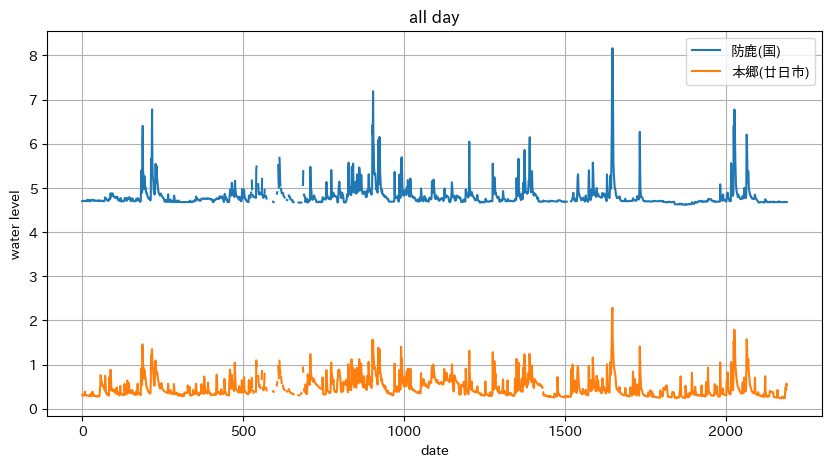

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(bouroku_water, label='防鹿(国)')
plt.plot(hongou_water, label='本郷(廿日市)')
plt.title('all day')
plt.xlabel('date')
plt.ylabel('water level')
plt.legend()
plt.grid()
plt.show()

観測所（観測する川）によって水位のスケールは時期に関係なく異なるようです。
また多少周期性が見られそうです。
1年単位で確認してみます。

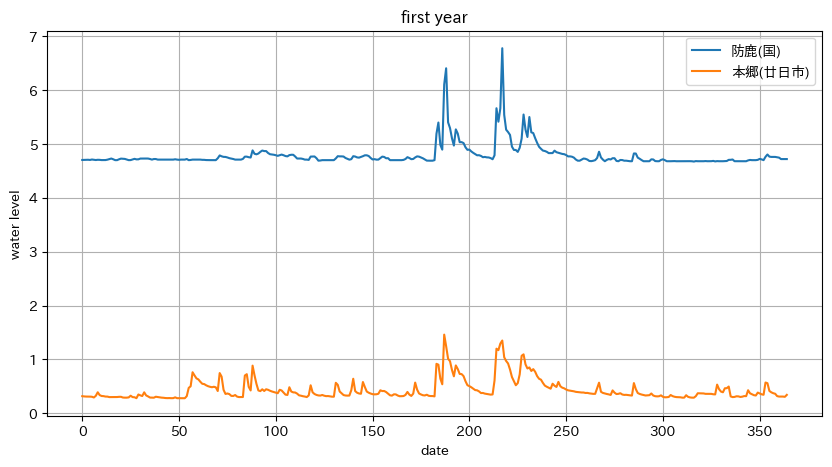

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(bouroku_water[:365], label='防鹿(国)')
plt.plot(hongou_water[:365], label='本郷(廿日市)')
plt.title('first year')
plt.xlabel('date')
plt.ylabel('water level')
plt.legend()
plt.grid()
plt.show()

date180~230の水位が上昇しているあたりが梅雨でしょうか

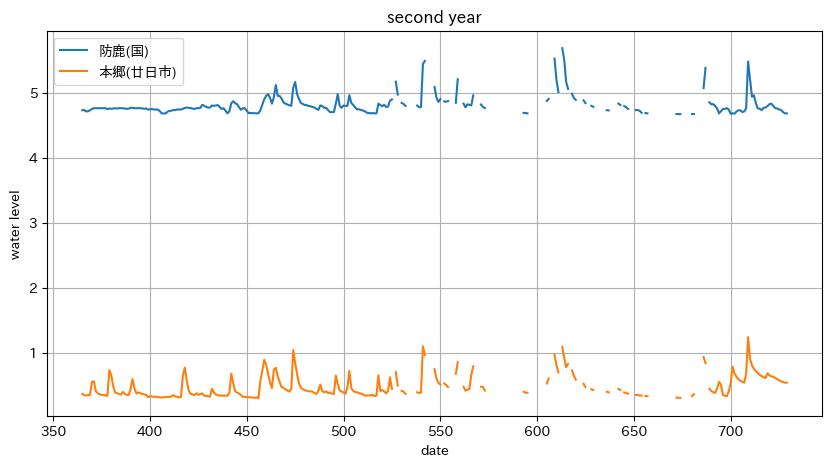

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(bouroku_water[365:730], label='防鹿(国)')
plt.plot(hongou_water[365:730], label='本郷(廿日市)')
plt.title('second year')
plt.xlabel('date')
plt.ylabel('water level')
plt.legend()
plt.grid()
plt.show()

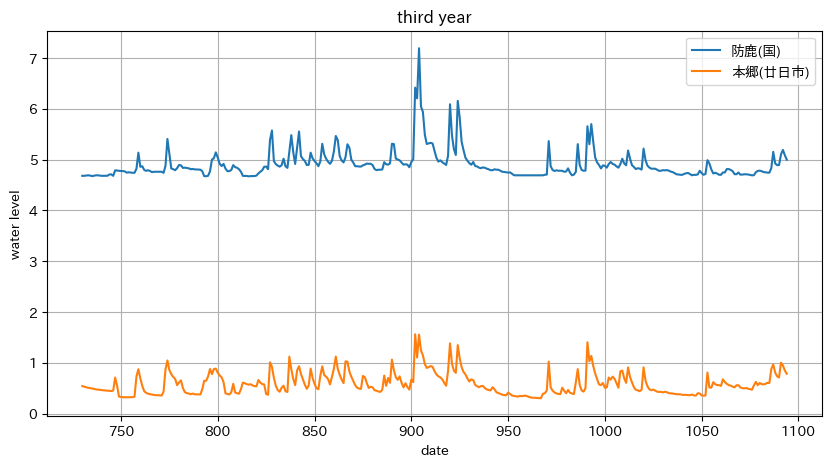

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(bouroku_water[730:1095], label='防鹿(国)')
plt.plot(hongou_water[730:1095], label='本郷(廿日市)')
plt.title('third year')
plt.xlabel('date')
plt.ylabel('water level')
plt.legend()
plt.grid()
plt.show()

緯度経度から観測所が近い雨量データと合わせてプロットしてみます。



In [52]:
water_stations[water_stations['観測所名称']=='防鹿(国)']

,観測所名称,フリガナ,水系名,河川名,事務所,市町,データ所管,住所,緯度,経度,入力時使用,評価対象
148,防鹿(国),ボウロク,小瀬川,小瀬川,廿日市支所,大竹市,国ダム,大竹市小方町防鹿,34.226389,132.184722,1,1


In [53]:
# 場所が近いの大竹(気)の雨量でプロット
rain_stations[rain_stations['事務所']=='廿日市支所']

,観測所名称,フリガナ,市町,水系名,河川名,データ所管,住所,緯度,経度,事務所,入力時使用
283,大竹(気),オオタケ,NaN,その他,沿岸部,気象台,大竹市立戸,34.222763,132.218582,廿日市支所,1
284,廿日市津田(気),ハツカイチツタ,NaN,小瀬川,林川,気象台,廿日市市津田,34.370487,132.175842,廿日市支所,1


In [54]:
# 雨量データ前処理
for i in range(24):
    rain_data[f'{str(i).zfill(2)}:00:00'] = pd.to_numeric(rain_data[f'{str(i).zfill(2)}:00:00'], errors='coerce')

rain_data['mean'] = rain_data[rain_data.columns[3:]].mean(axis=1)
otake_rain = rain_data[rain_data['station']=='大竹(気)'][['date', 'mean']].set_index('date')

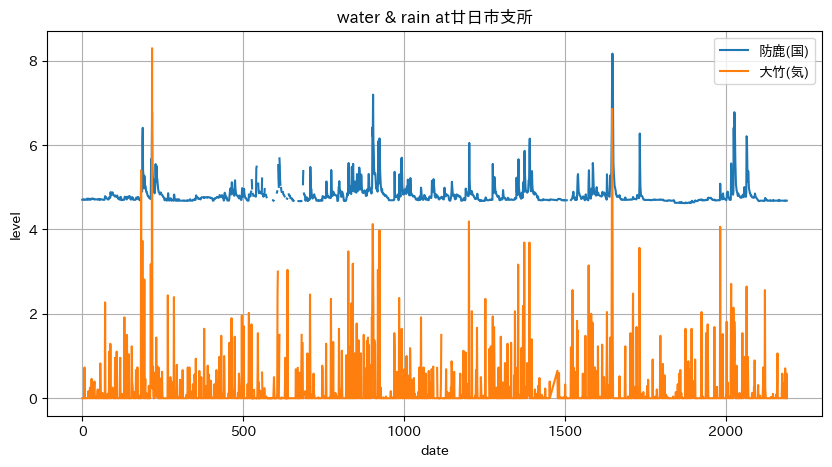

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(bouroku_water, label='防鹿(国)')
plt.plot(otake_rain, label='大竹(気)')
plt.title('water & rain at廿日市支所')
plt.xlabel('date')
plt.ylabel('level')
plt.legend()
plt.grid()
plt.show()

雨量と水位は相関がありそうなことを確認できます。

### [3. モデルの作成]

投稿ファイルは下記ディレクトリ構造を参考に作成ください。  
予測モデルはpredictor.pyにコーディングいただきます。  
※投稿ファイル詳細はreadme.mdをご参照ください。  

<pre>
tutorial_submit
├── model              必須: 学習済モデルを置くディレクトリ
│   └── ...
├── src                必須: Pythonのプログラムを置くディレクトリ
│   ├── predictor.py   必須: 最初のプログラムが呼び出すファイル
│   └── ...            その他のファイル (ディレクトリ作成可能)
└── requirements.txt   任意: 追加で必要なライブラリ一覧
</pre>

tutorial_submit > src > predictor.py

In [57]:
import pandas as pd

class ScoringService(object):
    @classmethod
    def get_model(cls, model_path):
        """Get model method

        Args:
            model_path (str): Path to the trained model directory.

        Returns:
            bool: The return value. True for success.
        """
        cls.model = None

        return True

    @classmethod
    def predict(cls, input): # 前日の水位をそのまま予測とするモデル
        """Predict method

        Args:
            input: meta data of the sample you want to make inference from (dict)

        Returns:
            dict: Inference for the given input.

        """
        stations = input['stations']
        waterlevel = input['waterlevel']
        merged = pd.merge(pd.DataFrame(stations, columns=['station']), pd.DataFrame(waterlevel))
        merged['value'] = merged['value'].replace({'M':0.0, '*':0.0, '-':0.0, '--': 0.0, '**':0.0})
        merged['value'] = merged['value'].fillna(0.0)
        merged['value'] = merged['value'].astype(float)

        prediction = merged[['hour', 'station', 'value']].to_dict('records')

        return prediction


### [4. run_testを使ったモデルの検証]

予測モデルが作成できたら本番環境を模したrun_testを使ってモデルの検証を行います。  
run_testの操作はwindowsであればコマンドプロンプト、macであればターミナルで行います。  
!を使うことでnotebookのセル上での実行も可能ですので、本チュートリアルではこの方法で検証を行います。   

「1. 準備」より、ご自身のディレクトリ構造を再確認いただき、下記を参考に引数を設定し実行ください。   

readme.mdより   

引数"--exec-path"には実装した予測プログラム("predictor.py")が存在するパス名を指定する.  
引数"--data-dir"には配布された学習用データ"train"のパス名を指定する.  
引数"--start-date"には検証用データを作成するときの最初の日にちを0以上の整数値を指定する.  
引数"--end-date"には検証用データを作成するときの最後の日にちを0以上の整数値を指定する.  
"--start-date"で指定した値よりも大きい値を設定すること.   

In [58]:
# 検証データを後半25%のdate1642以降とした場合
!python run_test/run.py  --exec-path run_test/tutorial_submit/src --data-dir run_test/train --start-date 1642 --end-date 2190

python: can't open file '/Users/klynoaguilar/Desktop/My_Githab/Signate-Hiroshima-Quest2022/run_test/run.py': [Errno 2] No such file or directory
